# **_CS336.M11.KHCL_**
---
Team members

|No.| Full name         |Student ID       |Team role      |Github|
|:-:|:------------------|:---------:|:--------:|:-----------:|
| 1	|[Nguyễn Trung Tuấn](https://www.facebook.com/trungtuan.nguyen.509994)	| 19552477	| ![](https://img.shields.io/badge/-Leader-yellow) |[lavatus](https://github.com/lavatus)|
| 2	|[Dương Nguyễn Thuận](https://www.facebook.com/dnthuan.97)	| 19522312	| ![](https://img.shields.io/badge/-Member-yellow)  |[DNThuan](https://github.com/DNThuan)|
| 3	|[Trịnh Nhật Tân](https://www.facebook.com/8thJunie)	  | 19522179	| ![](https://img.shields.io/badge/-Member-yellow)  |[trnhattan](https://github.com/trnhattan)|


# Essential modules

In [ ]:
import os, sys, copy
import cv2
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm, notebook

from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Resizing, Rescaling, Input, \
                                    MaxPooling2D, Flatten

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CS336

/content/drive/MyDrive/third_yr/CS336


In [ ]:
DATAPATH = "/content/drive/MyDrive/CS336"

# Essential functions

Hàm sắp xếp các `tuple` theo thứ tự giảm dần

In [ ]:
def Sort_Tuple(tup): 
    tup.sort(key = lambda x: x[1]) 
    return tup 

---
Hàm tính `ap` như chúng em đã giới thiệu bằng `pseudocode` trong báo cáo

```python
def compute_ap(groundtruth, ranked_list):
    """
        groundtruth: danh sách các groundtruth tương ứng với câu query đó.
        ranked_list: kết quả trả về đã được sắp xếp giảm dần theo khoảng cách
    """
```


In [ ]:
def compute_ap(rel, ranked_list):
    ap = 0.0
    precision = 1.0
    intersect_size = 0
    precision_list = []
    j = 0
    for i in range(len(ranked_list)):
        if ranked_list[i] in rel:
            intersect_size += 1
            precision = intersect_size / (j + 1.0)
            precision_list.append(precision)
        j += 1
    ap = np.array(precision_list).mean()
    return ap

---
Hàm trả về `index` các ảnh có trong cluster mà query đó thuộc về
```python
def predict(IMGPATH, kmeans, features):
    """
        IMGPATH: đường dẫn hình của câu query.
        kmeans: thuật toán `kmeans` đã được fit với các features, và số cụm trước đó
        features: numpy.array các features
    """
```

In [ ]:
def predict(IMGPATH, kmeans, features):
  query_img = cv2.imread(IMGPATH)
  query_img = cv2.resize(query_img, input_shape[: 2])
  query_img = tf.expand_dims(tf.convert_to_tensor(query_img), axis=0)

  query_features = model.predict(query_img, batch_size=None)

  label_query = kmeans.predict(query_features.astype(np.float32))

  rank_list_features = []
  rank_list_index = []

  for index,label in enumerate(kmeans.labels_,0):
      if label == label_query:
          rank_list_features.append(features[index])
          rank_list_index.append(index)

  sim = []

  for v in zip(rank_list_features, rank_list_index):
      cos_sim = np.dot(query_features, v[0]) / (np.linalg.norm(query_features) * np.linalg.norm(v[0]))
      sim.append((cos_sim,v[1])) 

  relevant_ans = Sort_Tuple(sim)

  return relevant_ans

---
Hàm `plot` các kết quả trả về của các hình ảnh có trong cluster theo thứ tự giảm dần về khoảng cách.

```python
def plot_result(IMGPATH, kmeans, features):
    """
        IMGPATH: đường dẫn hình của câu query.
        kmeans: thuật toán `kmeans` đã được fit với các features, và số cụm trước đó
        features: numpy.array các features
    """
```

In [ ]:
def plot_result(IMGPATH, kmeans, features):
  relevant_ans = predict(IMGPATH, kmeans, features)
  for ans in relevant_ans[:len(relevant_ans) // 2]:
      img = cv2.imread(f"{data_df.iloc[ans[1]][1]}")
      plt.figure(figsize=(8, 8))
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()

---
Hàm tính `mAP` cho toàn bộ query

```python
def plot_result(IMGPATH, kmeans, features):
    """
        IMGPATH: đường dẫn hình của câu query.
        kmeans: thuật toán `kmeans` đã được fit với các features, và số cụm trước đó
        features: numpy.array các features
    """
```


In [ ]:
def compute_mAP(DATAPATH, kmeans, features):
  ap =[] 
  for q in sorted(os.listdir(f"{DATAPATH}/query")): 
    IMGPATH = f"/content/drive/MyDrive/CS336/query/{q}"
    relevant_ans = predict(IMGPATH, kmeans, features)
    ranked_list = []
    for ans in relevant_ans:
      ranked_list.append(f"{data_df.iloc[ans[1]][1]}".split('/')[-1].split('.')[0])

    gt = []
    grd = f"{q[: q.rindex('_')]}.txt"
    with open(f'/content/drive/MyDrive/CS336/gt/{grd}') as gt_f:
        gt = [line.strip() for line in gt_f.readlines()]

    q_ap = compute_ap(gt, ranked_list)
    ap.append(q_ap)
  return np.array(ap).mean()

# File indexing

## Create file indexing

In [ ]:
data_df = pd.DataFrame(columns=['index', 'path'])

In [ ]:
i = 0
for file in sorted(os.listdir(f"/content/drive/MyDrive/CS336/dataset")):
    data_df.loc[i] = [i, f"/content/drive/MyDrive/CS336/dataset/{file}"]
    i += 1

## Load index

In [ ]:
data_df = pd.read_csv("./index.csv", index_col=0)
data_df.head()

,index,path
0,0,/content/drive/MyDrive/CS336/dataset/all_souls...
1,1,/content/drive/MyDrive/CS336/dataset/all_souls...
2,2,/content/drive/MyDrive/CS336/dataset/all_souls...
3,3,/content/drive/MyDrive/CS336/dataset/all_souls...
4,4,/content/drive/MyDrive/CS336/dataset/all_souls...


# Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
base_model = ResNet101(include_top=True, weights='imagenet', input_shape=input_shape)
base_model._name = "ResNet101"

model = Model(inputs = base_model.input, outputs = base_model.layers[-2].output)
# model.summary()

179658752/179648224 [==============================] - 4s 0us/step


## Load features

Để tiện lợi cho việc sử dụng, thì chúng em đã lưu các features vào `features.npy`. 

In [ ]:
with open('./feature_vectors/ResNet101_features.npy', 'rb') as f:
    features = np.load(f)

# Evaluation

In [ ]:
list_mAP = []
for i in notebook.tqdm_notebook(range(50,550, 50)):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(features)
  list_mAP.append(compute_mAP(DATAPATH, kmeans, features))

  0%|          | 0/10 [00:00<?, ?it/s]

[]

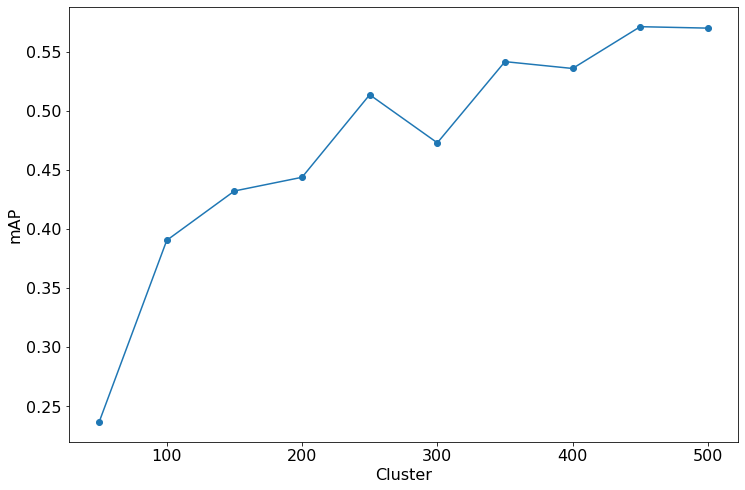

In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 16})
plt.plot(range(50,550,50), list_mAP, marker='o')
plt.xlabel('Cluster')
plt.ylabel('mAP')
plt.plot()

In [ ]:
np.around(np.array(list_mAP), decimals=3)

array([0.237, 0.39 , 0.432, 0.444, 0.514, 0.473, 0.542, 0.536, 0.571,
       0.57 ])

In [ ]:
plot_result("/content/drive/MyDrive/CS336/query/all_souls_1_query.jpg", kmeans, features)